In [1]:
#Import modules data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import h5py
from EventPreProcess import EventPreProcess

In [2]:
#load data
data_dir = 'C:/Users/user/Desktop/Datasets/PENN_DAVIS_DATASET/indoor_flying/'
event_data = h5py.File(data_dir + 'indoor_flying1_data.hdf5')
gt_data = h5py.File(data_dir + 'indoor_flying1_gt.hdf5')

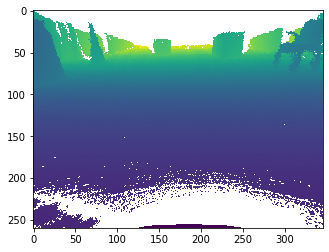

In [2]:
plt.imshow(gt_data['davis']['left']['depth_image_rect'][100])

In [3]:
print(event_data['davis']['left']['events'][1000])

[ 3.35000000e+02  2.34000000e+02  1.50464518e+09 -1.00000000e+00]


In [4]:
time_steps = np.linspace(gt_data['davis']['left']['depth_image_rect_ts'][0], gt_data['davis']['left']['depth_image_rect_ts'][-1], 100)
event_images = EventPreProcess.ConcatenateEvents(event_data['davis']['left']['events'], time_steps)

Percentage finished: 0.0
Percentage finished: 0.16
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.5582
Percentage finished: 0.55

In [5]:
time_steps = np.linspace(gt_data['davis']['left']['depth_image_rect_ts'][0], gt_data['davis']['left']['depth_image_rect_ts'][-1], 100)
event_binned_images = EventPreProcess.EventBinning(event_data['davis']['left']['events'], time_steps)

Percentage finished: %d 0.0
Percentage finished: %d 0.00011363552375813925
Percentage finished: %d 0.000396622800559209
Percentage finished: %d 0.001269320881703643
Percentage finished: %d 0.0019905049311705583
Percentage finished: %d 0.0056259178253842005


KeyboardInterrupt: 

In [4]:
frame_images = EventPreProcess.SelectFrames(event_data['davis']['left']['image_raw'], event_data['davis']['left']['image_raw_ts'], time_steps)

depth_images = EventPreProcess.SelectFrames(gt_data['davis']['left']['depth_image_rect'], gt_data['davis']['left']['depth_image_rect_ts'], time_steps)

In [20]:
#Vertically and horizontaly flip images for augmentation
event_binned_images.extend(EventPreProcess.FlipImages(event_binned_images, axis=0))
event_binned_images.extend(EventPreProcess.FlipImages(event_binned_images, axis=1))

frame_images.extend(EventPreProcess.FlipImages(frame_images, axis=0))
frame_images.extend(EventPreProcess.FlipImages(frame_images, axis=1))


depth_images.extend(EventPreProcess.FlipImages(depth_images, axis=0))
depth_images.extend(EventPreProcess.FlipImages(depth_images, axis=1))

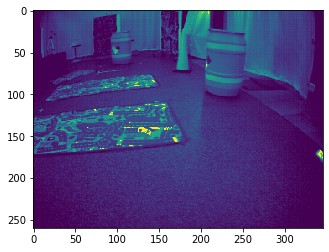

In [22]:
plt.imshow(frame_images[250])

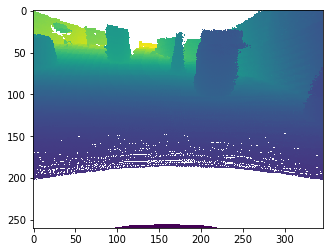

In [23]:
plt.imshow(depth_images[250])

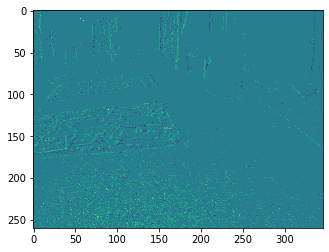

In [24]:
plt.imshow(event_binned_images[250][:,:,0])

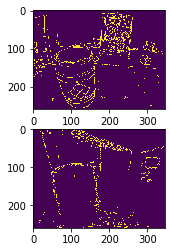

In [25]:
#Edge detection
frame_edges = EventPreProcess.EdgeDetection(frame_images)
depth_edges = EventPreProcess.EdgeDetection(depth_images, convert=True)

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.imshow(np.array(frame_edges[70]).reshape(260, 346))
ax.autoscale(False)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax, sharey=ax)
ax2.imshow(np.array(depth_edges[70]).reshape(260, 346))
ax2.autoscale(False)
plt.show()

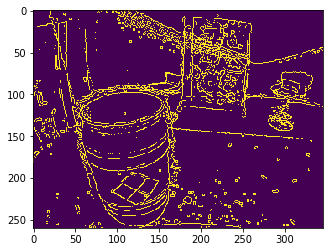

In [26]:
edge_images = EventPreProcess.BinaryAddImages(frame_edges, depth_edges)

plt.imshow(edge_images[70])

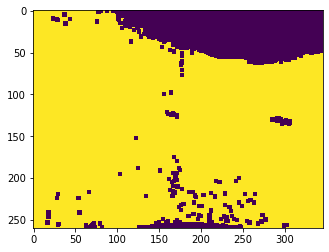

In [27]:
eroded_depth_images = EventPreProcess.ErodeImages(depth_images, binary_format=True)

plt.imshow(eroded_depth_images[70])

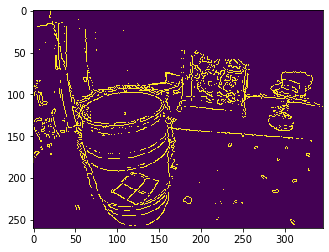

In [28]:
filtered_edge_images = EventPreProcess.MultiplyImages(edge_images, eroded_depth_images)

plt.imshow(filtered_edge_images[70])

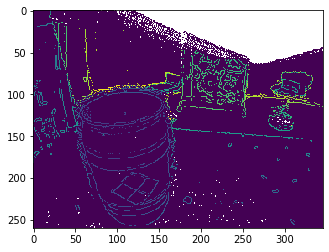

In [29]:
depth_edge_images = EventPreProcess.MultiplyImages(depth_images, filtered_edge_images)

plt.imshow(depth_edge_images[70])

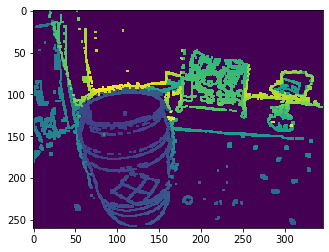

In [30]:
diluted_depth_edge_images = EventPreProcess.DiluteImages(depth_edge_images,kernel_size=3,  binary_format=False)

plt.imshow(diluted_depth_edge_images[70])

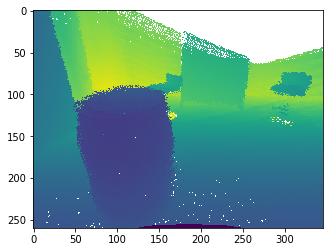

In [31]:
plt.imshow(depth_images[70])

In [41]:
print(np.array(event_binned_images)[10,:,:,0:2])

[[[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [2. 0.]
  [1. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [2. 1.]
  [0. 0.]
  [1. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [2. 1.]
  [1. 0.]
  [0. 0.]]

 ...

 [[0. 1.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 1.]
  [1. 0.]
  [1. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [1. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [1. 0.]
  [0. 0.]
  [0. 0.]]]


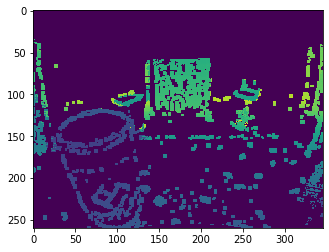

In [44]:
#Mask depth image based on event profile
event_mask = EventPreProcess.EdgeDetection(np.array(event_binned_images)[:,:,:,0], convert=True)

diluted_event_mask = EventPreProcess.DiluteImages(event_mask,kernel_size=3,  binary_format=True)

event_masked_depth_image = EventPreProcess.MultiplyImages(depth_images, diluted_event_mask)
event_masked_depth_image = EventPreProcess.DiluteImages(event_masked_depth_image,kernel_size=1,  binary_format=False)

plt.imshow(event_masked_depth_image[30])

In [45]:
#write data
hf = h5py.File('indoor_flying_augmented.hdf5', 'w')
hf.create_dataset('event_images', data=event_images)
hf.create_dataset('event_binned_images', data=event_binned_images)
hf.create_dataset('event_mask_images', data=event_mask)
hf.create_dataset('diluted_event_mask_images', data=diluted_event_mask)
hf.create_dataset('event_masked_depth_images', data=event_masked_depth_image)
hf.create_dataset('depth_images_timed', data=depth_images)
hf.create_dataset('frame_images_timed', data=frame_images)
hf.create_dataset('edge_images', data=edge_images)
hf.create_dataset('eroded_depth_images', data=eroded_depth_images)
hf.create_dataset('depth_edge_images', data=depth_edge_images)
hf.create_dataset('diluted_depth_edge_images', data=diluted_depth_edge_images)
hf.create_dataset('time_steps', data=time_steps)
hf.close()


In [19]:
#load hf file
hfl = h5py.File('indoor_flying_preprocessed.hdf5', 'r')
event_images = list(hfl['event_images'])
event_binned_images = list(hfl['event_binned_images'])
event_mask = list(hfl['event_mask_images'])
diluted_event_mask = list(hfl['diluted_event_mask_images'])
event_masked_depth_image = list(hfl['event_masked_depth_images']) 
depth_images = list(hfl['depth_images_timed'])
frame_images = list(hfl['frame_images_timed'])
edge_images = list(hfl['edge_images'])
eroded_depth_images = list(hfl['eroded_depth_images'])
depth_edge_images = list(hfl['depth_edge_images'])
diluted_depth_edge_images = list(hfl['diluted_depth_edge_images'])
time_steps = list(hfl['time_steps'])